# DS-7331 Machine Learning Project 3
## Airbnb Clustering Tasks
### Allen Miller, Ana Glaser, Jake Harrison, Lola Awodipe

https://nbviewer.jupyter.org/github/allenmiller17/SMU_7331_ML1_Projects/blob/main/Project_2_Final_Team.ipynb

## Introduction

Our project utilizes Airbnb data from kaggle.com.

The main objective of this project is to perform cluster analyses to simply and potentially create more efficient classification models than the previous project.

### Table of Contents
0. Libraries and Loading Data
<br>
1. Business Understanding
    <br>
2. Data Understanding
    <br>
    2.1 Data Meaning
    <br>
    2.2 Data Quality
    <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.1 Missing Values
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.2 Outliers
    <br>
3. Modeling and Evaluation
    <br>
    3.1 KMeans Clustering Analysis
    <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1.1 Selecting Optimal K-Clusters Value
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1.2 Internal And External Validation Measures
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1.3 Results
        <br>
    3.2 Hierichial Clustering Analysis
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.1 Selecting Optimal Clusters
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.2 Validation Measures
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.3 Results
        <br>
     3.3 DBScan Clustering Analysis
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.1 Selecting Optimal Clusters
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.2 Validation Measures
        <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.3 Results
        <br>
     3.4 Comparison of all Clustering Techniques
     <br>
4. Deployment
<br>
5. Exceptional Work - Applying cluster analyses to Classification Models?

### 0. Libraries and Loading Data

In [1]:
#loading libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

import numpy as np
from scipy import stats

from sklearn import metrics as mt

from sklearn.cluster import KMeans

In [ ]:
#restart button
pdata = pd.read_csv("airbnb1.csv")
pdata['price'] = np.exp(pdata.log_price)
pdata = pdata.dropna()

#transforming the property type to a binary classification
value_list = ["Apartment","House","Condominium","Townhouse","Loft"]
boolean_series = ~pdata.property_type.isin(value_list)
filtered_df = pdata[boolean_series]

filtered_df.head(100)

for i in list (filtered_df.index):
    pdata.loc[i,'property_type'] = "other"

#transforming the longitude and latitude variables to East / West
pdata["region"] = pd.cut(pdata.longitude,[-200,-100,0],2,labels=["West","East"])

pdata_all=pdata.copy()

#Encoding boolean and categorical variables
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                "property_type":     {"Apartment": 0,"House": 1,"Condominium": 2,"Townhouse": 3,"Loft": 4, "other": 5},
                "region": {"East": 0, "West": 1},
                "room_type": {"Entire home/apt": 0, "Private room": 1, "Shared room": 2},
                "bed_type": {"Real Bed": 0, "Futon": 1, "Pull-out Sofa": 2, "Couch": 3, "Airbed": 4},
                "city": {"NYC": 0, "SF": 1, "DC": 2, "LA": 3, "Chicago": 4, "Boston": 5},
                "cancellation_policy": {"strict": 0, "moderate": 1, "flexible": 2, "super_strict_30": 3, "super_strict_60": 4}
                    }

pdata=pdata.replace(replaceStruct)

pdata.drop(['description','host_response_rate','first_review','host_since','last_review','zipcode','id','neighbourhood','host_has_profile_pic','cleaning_fee','instant_bookable','host_identity_verified','property_type','room_type','bed_type','cancellation_policy','city','region','longitude','latitude'], axis=1, inplace=True)

from scipy.stats import zscore

pdata_z = pdata.apply(zscore)



In [2]:
pdata = pd.read_csv("airbnb1.csv")

In [ ]:
pdata.head()

### 1. Business Understanding

For our project, we decided to use AirBnb data from six major cities in the United States from kaggle.com. Our objective is to classify the type of property based on the data attributes like city, number of reviews, bathrooms, bedrooms and number of people it accommodates. 

First we will evaluate the various clustering techniques by visually inspecting the separation and interpretability of the clustering models. We will also compare the effectiveness of our clusters by evaluating the sillhouette score and the inertia value for each technique.  

Then we will append the clusters to the dataset as a feature to determine if the classification task is improved by these regressors.

To assess the effectiveness of our classification, we will look at the accuracy, precision, recall and evaluate the confusion matrix results.






### 2. Data Understanding


The number of reviews feature showed data that was heavily skewed to the left.  Because normality is not an assumption for clustering and classification tasks, we weren't worried about having a normal distribution for our feature observations, so we chose not to transform any of these variables.

The attribute of neighborhood made our data very sparse and it increased run time dramatically, when we tested the models with and without it, the difference was negligible, so the cost benefit of run time vs model performance seemed like a fair trade-off.

#### 2.1 Data Meaning

In [3]:
pdata['price'] = np.exp(pdata.log_price)

Adding the price will give our team an idea on how dispersed our data really is, and can easily display if we have any outliers within this dataset.

In [ ]:
pdata.info()

In [ ]:
pdata.skew()

#### 2.2 Data Quality

##### 2.2.1 Missing Values

Given the volume of our data, we were able to reduce incomplete records with missing values and still retain a significant amount of records to evaluate.

In [4]:
pdata = pdata.dropna()

##### 2.2.2 Outliers


We also evaluated the number of unique values found in the categorical variables, we decided to eliminate the neighborhood attribute since it had 590 distinct values.  This made the model run time very slow and only gained a modest amount of accuracy.

In [ ]:
pdata.nunique()

The property type was a very skewed attribute, so we reduced it to the top 5 property types and the rest were labeled as other.

We proceeded to encode the categorical variables that we were going to reserve for our classification models, and transformed the longitude variable to a region called east and west.

We then dropped all of the other columns that would not be used in the proceeding models, like property descriptions, and those that resulted lacking in predictive power, as demonstrated in our previous experiments.


In [5]:
#transforming the property type to a binary classification
value_list = ["Apartment","House","Condominium","Townhouse","Loft"]
boolean_series = ~pdata.property_type.isin(value_list)
filtered_df = pdata[boolean_series]

filtered_df.head(100)

for i in list (filtered_df.index):
    pdata.loc[i,'property_type'] = "other"

#transforming the longitude and latitude variables to East / West
pdata["region"] = pd.cut(pdata.longitude,[-200,-100,0],2,labels=["West","East"])

pdata_all=pdata.copy()

In [ ]:
#evaluating the data after transformation
pdata.head()

In [6]:
#Encoding boolean and categorical variables
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                "property_type":     {"Apartment": 0,"House": 1,"Condominium": 2,"Townhouse": 3,"Loft": 4, "other": 5},
                "region": {"East": 0, "West": 1},
                "room_type": {"Entire home/apt": 0, "Private room": 1, "Shared room": 2},
                "bed_type": {"Real Bed": 0, "Futon": 1, "Pull-out Sofa": 2, "Couch": 3, "Airbed": 4},
                "city": {"NYC": 0, "SF": 1, "DC": 2, "LA": 3, "Chicago": 4, "Boston": 5},
                "cancellation_policy": {"strict": 0, "moderate": 1, "flexible": 2, "super_strict_30": 3, "super_strict_60": 4}
                    }

pdata=pdata.replace(replaceStruct)
pdata_cls=pdata.copy()


In [7]:
pdata.drop(['description','host_response_rate','first_review','host_since','last_review','zipcode','id','neighbourhood','host_has_profile_pic','cleaning_fee','instant_bookable','host_identity_verified','property_type','room_type','bed_type','cancellation_policy','city','region','longitude','latitude'], axis=1, inplace=True)


In [ ]:
#pdata.drop(['longitude','latitude'], axis=1, inplace=True)

In [8]:
pdata.head()

,log_price,accommodates,bathrooms,number_of_reviews,review_scores_rating,bedrooms,beds,price
1,5.129899,7,1.0,6,93.0,3.0,3.0,169.0
2,4.976734,5,1.0,10,92.0,1.0,3.0,145.0
4,4.744932,2,1.0,4,40.0,0.0,1.0,115.0
5,4.442651,2,1.0,3,100.0,1.0,1.0,85.0
7,4.787492,2,1.0,9,93.0,1.0,1.0,120.0


In [11]:
pdata_all.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price,region
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,...,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,169.0,East
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,...,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,145.0,East
4,3808709,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,...,38.925627,-77.034596,Columbia Heights,4,40.0,20009,0.0,1.0,115.0,East
5,12422935,4.442651,Apartment,Private room,2,1.0,Real Bed,strict,True,SF,...,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,85.0,West
7,13971273,4.787492,Condominium,Entire home/apt,2,1.0,Real Bed,moderate,True,LA,...,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0,120.0,West


In [ ]:
pdata.nunique()

### 3. Model and Evaluation

#### 3.1 K-Means Clustering Analysis

##### 3.1.1 Selecting Optimal K-Clusters

There is room for intrepetation on which k is the best option. The elbow method is difficult to apply in this instance because there is not a specific point that the elbow starts. One could argue the elbow begins at 3, 6, 9, or 11. Due to that, our team decided to refer to the yellowbrick package. This package, when used properly, will select an optimal k value based on the distortion score.

In [12]:
#Scale the data and deploy model

from scipy.stats import zscore

pdata_z = pdata.apply(zscore)

Text(0.5, 1.0, 'K Optimization Graph')

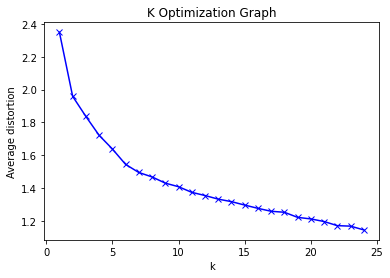

In [13]:
#https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

from scipy.spatial.distance import cdist
clusters=range(1,25)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k, algorithm='auto',init='k-means++',n_jobs=20, random_state=2345)
    model.fit(pdata_z)
    prediction=model.predict(pdata_z)
    meanDistortions.append(sum(np.min(cdist(pdata_z, model.cluster_centers_, 'euclidean'), axis=1)) / pdata_z
                           .shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('K Optimization Graph')

In [ ]:
#https://towardsdatascience.com/selecting-optimal-k-for-k-means-clustering-c7579fd2e926

from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(model, pdata_z,k=(1,25),timings=False)

In [ ]:
# referenced from class example
from sklearn import metrics
from sklearn.cluster import KMeans

seuclid = []
scosine = []
k = range(2,25)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++", random_state=2345).fit(pdata_z)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(pdata_z, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(pdata_z, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

Utilizing this function in determining the optimal k clusters to use, we will move forward with 6 clusters.

In [ ]:
KNNModel = KMeans(n_clusters=6, n_init = 3, random_state=2345)
KNNModel.fit(pdata_z)
prediction=KNNModel.predict(pdata_z)
pdata_z["KCLUSTER"] = prediction
pdata["KCLUSTER"] = prediction
pdata_all["KCLUSTER"] = prediction

In [ ]:
#Assess the distribution of clusters formed
pdata_z['KCLUSTER'].value_counts()  

In [ ]:
pdata_z.info()

In [ ]:
pdata_z.head()

In [ ]:
pdata_z.nunique()

Intercluster distance displays an embedded cluster centers in a two-dimensions with the distance to the centers preserved. The centers are stochastically updated, therefore updates the centroid after each assignment. The cluster bubbles are sized by the number of instances within those groups. Just because there is overlap in the two-dimensional space, does not imply they overlap in the original feature space. However, looking at the three-dimensional graph of the selected features, one could argue against this notion.

  **mds**: multidimensional scaling
  **tsne**: stochastic neighbor embedding
  
When comparing the two methods of evaluating the centroids, the stochastic neighbor is consistent and the multidimensional scaling centroid cluster positions change every time you run it,

In [ ]:
#https://towardsdatascience.com/selecting-optimal-k-for-k-means-clustering-c7579fd2e926

from yellowbrick.cluster import intercluster_distance

intercluster_distance(KNNModel, pdata_z, embedding='tsne', random_state=24)

In [ ]:
intercluster_distance(KNNModel, pdata_z, embedding='mds', random_state=24)

In [ ]:
intercluster_distance(KNNModel, pdata_z, embedding='mds', random_state=24)

In [ ]:
import plotly.express as px
pdata["strKCLUSTER"] = pdata["KCLUSTER"].astype(str)
fig = px.scatter_3d(pdata, x='review_scores_rating', y='price', z='number_of_reviews', color='strKCLUSTER', title="Comparing Scaled Reviews, Price, and Accomodations colored by Groups")
fig.update_layout(width = 550, height = 550,margin=dict(l=0, r=0, b=0, t=0))
fig.show()
#The number of ratings and the average rating relating to the price of the listing.

In [ ]:
fig05 = px.box(pdata_all, y="price", x="city", color="KCLUSTER", title ="Box Plot of the dataset with the accomodations by price and colored by groups", height=1000, width=1500)
fig05.update_layout(width = 900, height = 550,margin=dict(l=0, r=0, b=0, t=0))
fig05.show()


In [ ]:
fig06 = px.box(pdata_all, y="review_scores_rating", x="city", color="KCLUSTER", title ="Box Plot of the dataset with the cities by scaled average rating and colored by groups", height=1000, width=1500)
fig06.update_layout(width = 900, height = 550,margin=dict(l=0, r=0, b=0, t=0))
fig06.show()

In [ ]:
dataset=pdata[:]  #creating a copy of the data 
dataset['KmeansLabel']=KNNModel.labels_

In [ ]:
plt.scatter(dataset['price'], dataset['review_scores_rating'], c=KNNModel.labels_)
plt.title("Comparing Price to Ratings, colored by Groups")
plt.xlabel("Price")
plt.ylabel("Ratings")
plt.show()

In [ ]:
import plotly.express as px
fig1 = px.scatter(pdata_z, x='number_of_reviews', y='review_scores_rating', color='strKCLUSTER')
fig1.show()

In [ ]:
#fig1 = px.violin(pdata, y="price", x="accommodates", color="KCLUSTER", box=True, points="all")
#fig1.show()

#### 3.2 Hierichial Clustering Analysis

##### 3.2.1 Selecting Optimal Clusters

##### 3.2.2 Validation Measures

##### 3.2.3 Results

In [ ]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

In [ ]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

linkage_methods = ['single', 'complete', 'average', 'ward', 'median']

results_cophenetic_coef=[]

for i in linkage_methods :
    #plt.figure(figsize=(15,13))
    #plt.xlabel('sample index')
    #plt.ylabel('Distance')
    Z = linkage(pdata_z, i)
    cc, coph_dists = cophenet(Z , pdist(pdata_z))
    #dendrogram(Z,leaf_rotation=90.0, p=5, leaf_font_size=10, truncate_mode='level')
    #plt.tight_layout()
    #plt.title("Linkage Type: "+ i +" having cophenetic coefficient : "+str(round(cc,3)) )
    #plt.show()
    results_cophenetic_coef.append((i,cc))
    #print (i,cc)

In [ ]:
results_cophenetic_coef_df=pd.DataFrame(results_cophenetic_coef,columns=['LinkageMethod','CopheneticCoefficient'])
results_cophenetic_coef_df

In [ ]:
# cophenet index 
Z = linkage(pdata_z, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(pdata_z))

c

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=20)
plt.tight_layout()

In [ ]:
# cophenet index 
Z1 = linkage(pdata_z, metric='euclidean', method='ward')
c1, coph_dists1 = cophenet(Z1 , pdist(pdata_z))

c1

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - ward')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z1, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=100)
plt.tight_layout()

In [ ]:
# cophenet index 
Z2 = linkage(pdata_z, metric='euclidean', method='complete')
c2, coph_dists2 = cophenet(Z2 , pdist(pdata_z))

c2



In [ ]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - complete')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z2, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=20)
plt.tight_layout()


In [ ]:
# cophenet index 
Z3 = linkage(pdata_z, metric='euclidean', method='centroid')
c3, coph_dists3 = cophenet(Z3 , pdist(pdata_z))

c3



In [ ]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - centroid')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z2, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=20)
plt.tight_layout()


In [ ]:
max_d=5
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_d, criterion='distance')

In [ ]:
set(clusters)  # So there are 3 clusters which are formed 

In [ ]:
dataset['HierarchicalClusteringLabel']=clusters

In [ ]:
from sklearn.metrics import silhouette_score
Kmeans_score =  silhouette_score(dataset.drop('KmeansLabel',axis=1),dataset['KmeansLabel'])
print("Kmeans silhouette : ", Kmeans_score)


In [ ]:
Hierarchical_score = silhouette_score(dataset.drop('HierarchicalClusteringLabel',axis=1),dataset['HierarchicalClusteringLabel'])
print("Hierarchical silhouette ; ", Hierarchical_score)

In [ ]:
Kmeans_results=dataset.groupby('KmeansLabel').mean()
Kmeans_results

In [ ]:
Hierarchical_results=dataset.groupby('HierarchicalClusteringLabel').mean()
Hierarchical_results

In [ ]:
DBScan_results=dataset.groupby('labelsDBScan').mean()
DBScan_results

#### 3.3 DBScan Clustering Analysis

##### 3.3.1 Selecting Optimal Clusters

##### 3.3.2 Validation Measures

##### 3.3.3 Results

In [ ]:
from sklearn.neighbors import kneighbors_graph

db_minpts = 2

db_knn_graph = kneighbors_graph(pdata_z, db_minpts, mode = 'distance')

N2 = db_knn_graph.shape[0]
pdata_nn_distances = np.zeros((N2,1))
for i in range(N2):
    pdata_nn_distances[i] = db_knn_graph[i,:].max()
    
pdata_nn_distances = np.sort(pdata_nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), pdata_nn_distances, 'r.', markersize=2)
plt.title('Airbnb Dataset, sorted by neighbor distance')
plt.xlabel('Airbnb, Instance Number')
plt.ylabel('Airbnb, Distance to {0}th nearest neighbor'.format(db_minpts))
plt.grid()
plt.show()


In [ ]:
X_all = pdata_z[["log_price","accommodates","bathrooms","number_of_reviews","review_scores_rating","bedrooms","beds","price"]].values 
n_clusters = 10
#marker_colors = ['r', 'b', 'r', 'r', 'r', 'b', 'r', 'b']

scl_obj = StandardScaler()
scl_obj.fit(X_all) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_scaled= scl_obj.transform(X_all) # apply to training

In [ ]:
from sklearn.cluster import DBSCAN

modelDBSCAN = DBSCAN(eps=0.99, min_samples=db_minpts).fit(pdata_z)
labelsDBSCAN = modelDBSCAN.labels_
pdata['labelsDBSCAN'] = labelsDBSCAN



In [ ]:
modelDBSCANAll = DBSCAN(eps=0.8, min_samples=15).fit(X_scaled)

labelsDBSCANAll = modelDBSCANAll.labels_

In [ ]:
pdata.head()

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html


In [ ]:
plt.scatter(pdata_z.number_of_reviews, pdata_z.accommodates,  c=labelsDBSCAN, alpha=0.5)
plt.title("DBScan Clustering on number of Reviews vs property type")
plt.xlabel("No of Reviews")
plt.ylabel("Property Type")
plt.show()
# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
plt.scatter(pdata_z.number_of_reviews, pdata_z.accommodates,  c=labelsDBSCAN, alpha=0.5)
plt.title("DBScan Clustering on number of Reviews vs property type")
plt.xlabel("No of Reviews")
plt.ylabel("Property Type")
plt.show()

In [ ]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X_all)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))


In [ ]:
# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
X_3dAll = pdata_z.copy()

import plotly.express as px

fig = px.scatter_3d(pdata_z, x='log_price', y='beds', z='bedrooms', color='GROUP')
fig.show()

fig = px.scatter_3d(pdata_z, x='review_scores_rating', y='price', z='accommodates', color='GROUP')
fig.show()

In [ ]:
print(labelsDBSCAN)

In [ ]:
#Assess the distribution of clusters formed
pdata_z['labelsDBScan'] =   labelsDBSCAN
pdata['labelsDBScan'] =   labelsDBSCAN
dataset['labelsDBScan'] =   labelsDBSCAN

In [ ]:
pdata['labelsDBScan'].nunique()  

##### 2.3.2 K-Nearest Neighbors Classification

In [ ]:
get_ipython().run_line_magic('time', '')
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline


#pipe = make_pipeline(('scale', StandardScaler()),  ('knn', KNeighborsClassifier()))

pipe = Pipeline([('scale', StandardScaler()),  
                         ('knn', KNeighborsClassifier())]) 

# Define a range of hyper parameters for grid search
parameters = { 'knn__n_neighbors': [10,45,50]
              , 'knn__algorithm' : ["auto", "ball_tree", "kd_tree", "brute"]
             }

#Perform the grid search using accuracy as a metric during cross validation.
gridKnn = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy') # can try f1_micro, f1_maco accuracy....

#Use the best features from recursive feature elimination during the grid search
gridKnn.fit(X_train_scaled_cls, y_train_cls)

#display the best pipeline model identified during the grid search
gridKnn.best_estimator_

In [ ]:
gridKnn.best_params_

In [ ]:
KNNmodelFINAL = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 45) # get object
KNNmodelFINAL.fit(X_train_scaled_cls, y_train_cls)
KNNy_hat = KNNmodelFINAL.predict(X_test_scaled_cls)

In [ ]:
from sklearn.model_selection import cross_val_score
KNNaccuracies = cross_val_score(KNNmodelFINAL, X_scaled_cls, y=y_cls, cv=cv) # this also can help with parallelism
print(KNNaccuracies)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

print("Training accuracy",round(KNNmodelFINAL.score(X_train_scaled_cls,y_train_cls),ndigits=3))
print()
print("Testing accuracy",round(mt.accuracy_score(y_test_cls, KNNy_hat),ndigits=3))
print()
print('Confusion Matrix')
print(draw_cm(y_test_cls,KNNy_hat))

print(classification_report(y_test_cls,KNNy_hat))

In [ ]:
KNN_ac = round(mt.accuracy_score(y_test_cls, KNNy_hat),ndigits=3)

print(KNN_ac)

In [ ]:
Kmeans_results.plot.bar()

#### 3.4 Comparison of all Clustering Techniques

In [ ]:
from sklearn.cluster import AgglomerativeClustering
#Comparison of the Clustering
data = pdata_z

cls = DBSCAN(eps=0.99, min_samples=2)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=6, linkage='complete')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=6, random_state=12)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('Parch')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('SibSp')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()

### 4. Deployment

### 5. Exceptional Work